Using default yaw angle resolution...
Using default neighborhood dimensions...
Beginning LUT training...
Wind speed: 8
Wind direction: 0
yaw_angles: [2.53249208e+01 2.58345138e+01 4.80013169e-21]
Wind speed: 8
Wind direction: 0
yaw_angles: [2.53249208e+01 2.58345138e+01 4.80079782e-21]
Wind speed: 8
Wind direction: 0
yaw_angles: [2.53249208e+01 2.58345138e+01 4.80084223e-21]
Wind speed: 9
Wind direction: 0
yaw_angles: [2.53264801e+01 2.55820358e+01 1.10096625e-12]
Wind speed: 9
Wind direction: 0
yaw_angles: [2.53264801e+01 2.55820358e+01 1.10096625e-12]
Wind speed: 9
Wind direction: 0
yaw_angles: [2.53264800e+01 2.55820358e+01 1.10096625e-12]
Wind speed: 15
Wind direction: 0
yaw_angles: [11.85350838 23.23987611 20.11381007]
Wind speed: 15
Wind direction: 0
yaw_angles: [11.85146892 23.24633623 20.11482139]
Wind speed: 15
Wind direction: 0
yaw_angles: [11.8513364  23.24504024 20.11530015]
Using default yaw angle resolution...
Using default neighborhood dimensions...
Beginning LUT trainin

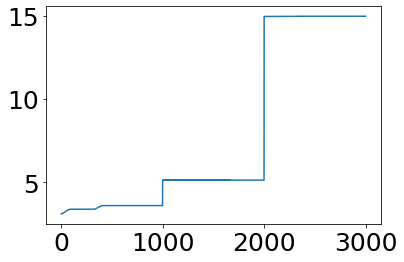

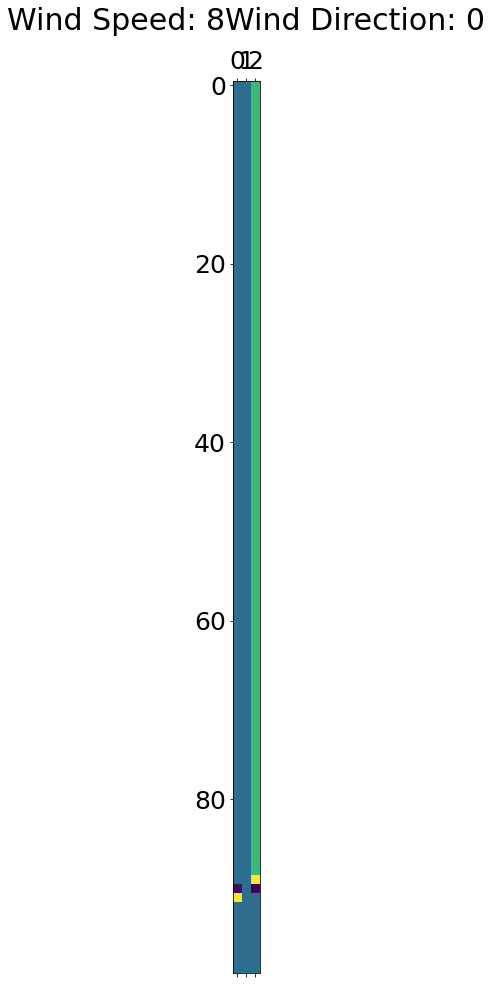

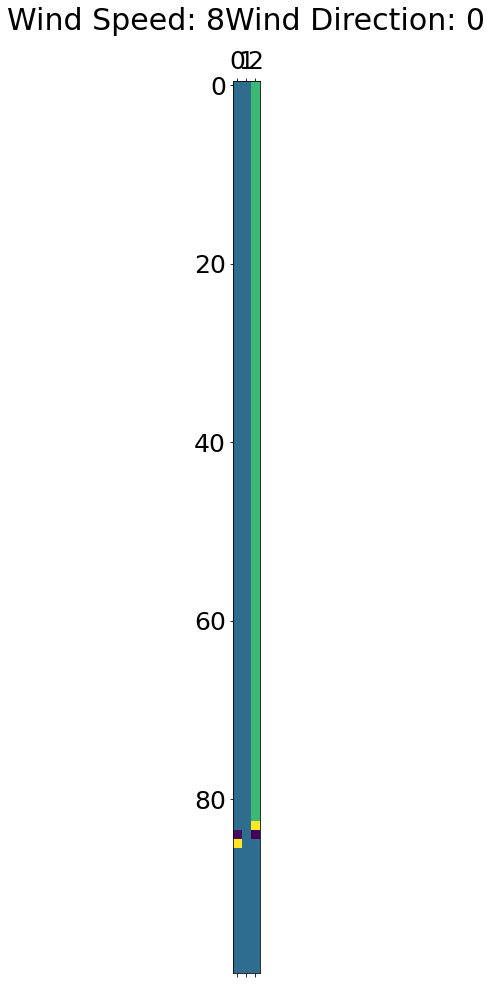

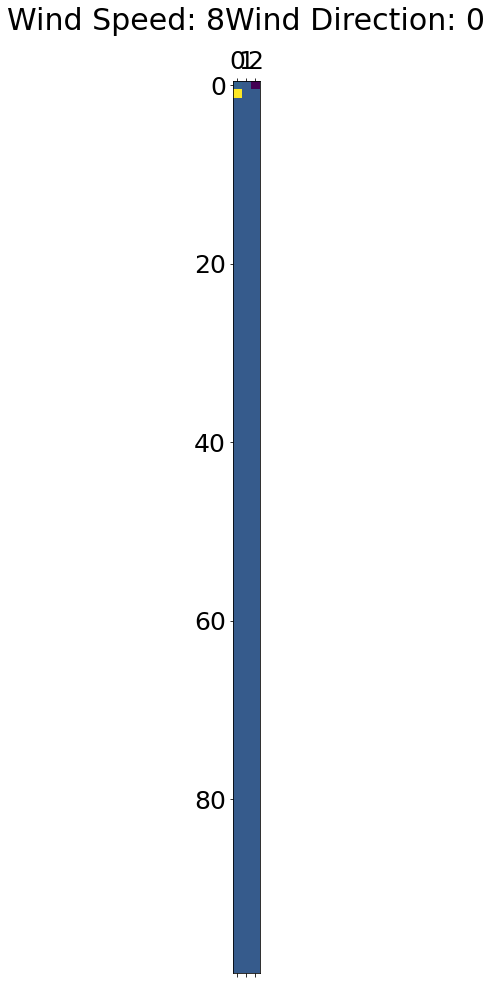

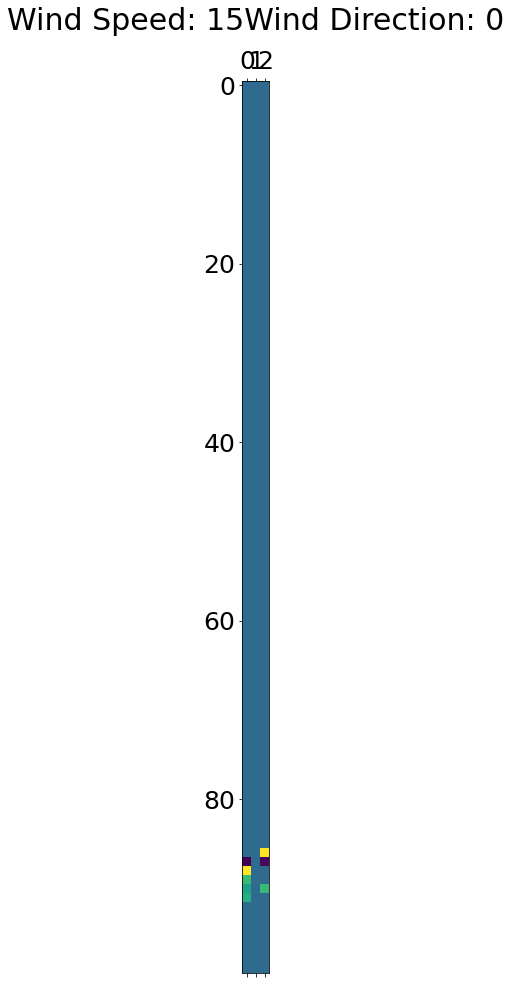

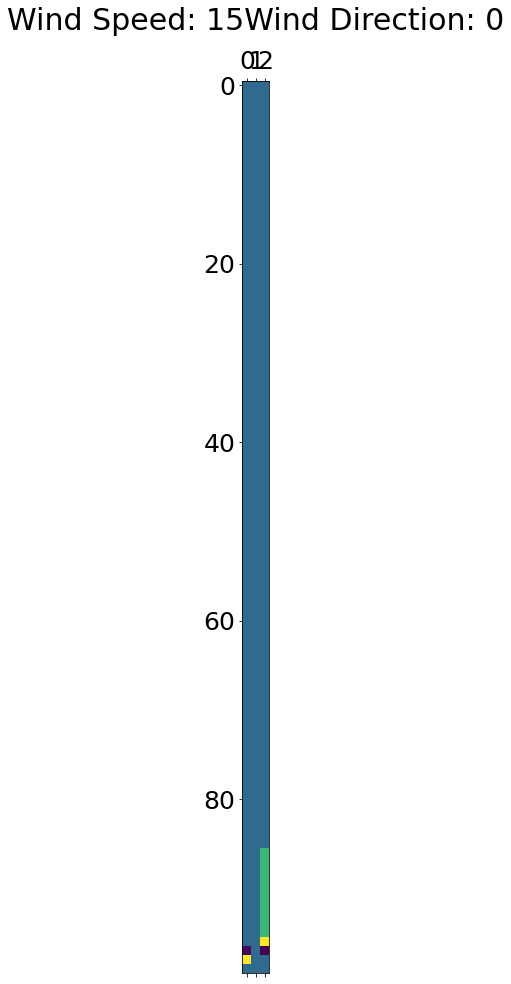

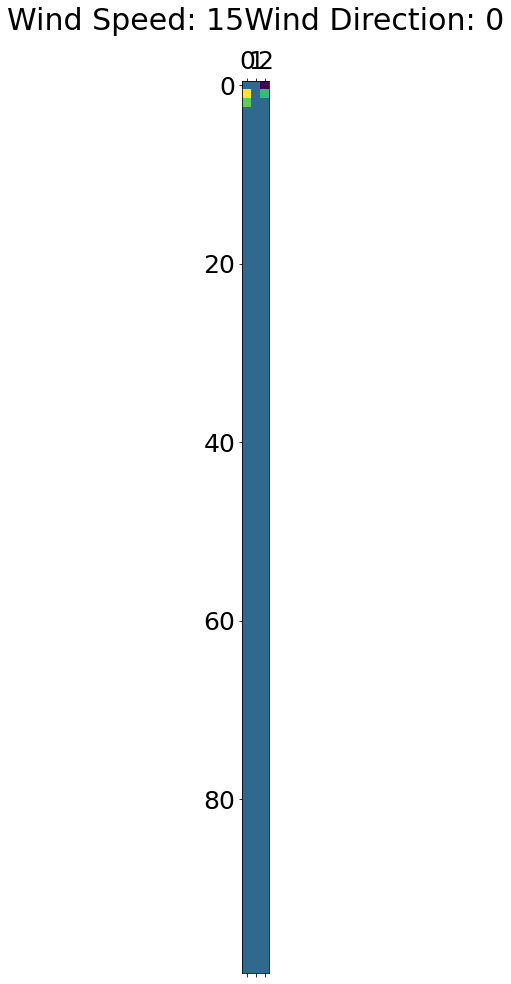

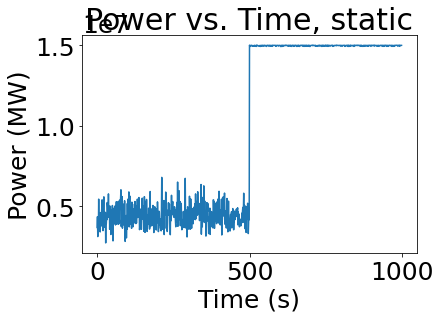

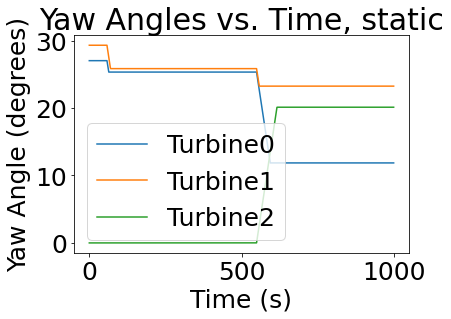

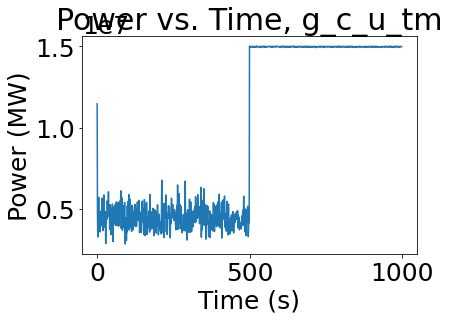

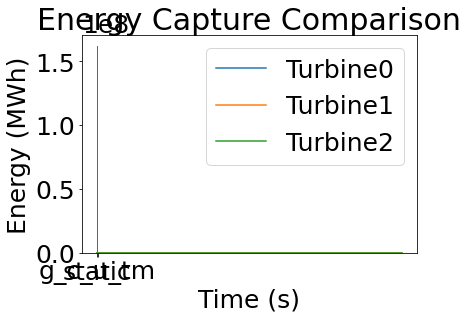

In [1]:
import sys
import floris.tools as wfct
from floris.tools.trainer import Trainer, LUT, TrainingMethod
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
import pickle
import math
from datetime import datetime
import floris.tools.train_run as tr
from floris.simulation.simulator import Simulator

TI = 5

mean_1 = 8
dev_1 = (TI/100)*mean_1

mean_2 = 15
dev_2 = (TI/100)*mean_2

total_time = 1000

wind_speeds = [8,9,15]#,10,11,12,13,14]
wind_dirs = [0, 0, 0]#, 5, 10]

wind_speed_profile_high_ti = {}

for i in range(total_time):
    if i < total_time/2:
        mean = mean_1
        dev = dev_1
    else:
        mean = mean_2
        dev = dev_2

    wind_speed_profile_high_ti[i] = np.random.normal(loc=mean, scale=dev)#np.random.uniform(low=8, high=8.3)
wind_speed_profile_high_ti[total_time] = np.nan

wind_dir_profile = tr.create_constant_wind_profile(wind_dirs, total_time)
wind_speed_profile = tr.create_constant_wind_profile(wind_speeds, total_time)

wind_profiles = [wind_speed_profile, wind_dir_profile]

# comment out wind_speeds entry if performing the stochastic sweep tests
parameters = {"wind_speeds": wind_speeds, "wind_directions": wind_dirs}

# NOTE: this is hardcoded right now
num_turbines = 3

#Static method
static_tm = TrainingMethod(static=True, num_turbines=num_turbines, name="static")

# Boltzmann method
b_c_n_tm = TrainingMethod(static=False, num_turbines=num_turbines, coord=None, action_selection="boltzmann", \
    reward_signal="constant", iterations=total_time, name="b_c_n")

g_c_u_tm = TrainingMethod(static=False, num_turbines=num_turbines, coord="up_first", action_selection="gradient", \
    reward_signal="constant", iterations=total_time, opt_window = math.floor(total_time/num_turbines), name="g_c_u_tm")

training_methods = [static_tm, g_c_u_tm]#, b_c_n_tm]
lut_sets = []
wind_speed_lists = []

num_sims = 10
#training_methods = []
# for i in range(num_sims):
#     name = "stoch_test_var_" + str(i)

#     tm = TrainingMethod(static=False, num_turbines=3, coord=None, action_selection="boltzmann", \
#         reward_signal="variable", iterations=1000, name=name)

#     training_methods.append(tm)

for training_method in training_methods:
    fi = wfct.floris_interface.FlorisInterface("example_input.json")
    D = fi.floris.farm.turbines[0].rotor_diameter
    fi.calculate_wake()
    # x and y coordinates of turbines in meters
    #layout_x = [0, 7*D, 14*D]
    #layout_y = [0, 0, 0]

    #fi.reinitialize_flow_field(layout_array=[layout_x, layout_y])
    #fi.calculate_wake()

    trainer = Trainer(fi, parameters, training_method, dyn_train=False)

    #prefix = "./paper_data/" + training_method.name
    #print(prefix)
    tic = datetime.now()
    lut_sets.append( trainer.train() )
    toc = datetime.now()

    #time_file_path = prefix + "_time.npy"
    #np.save(time_file_path, np.array([toc.timestamp()-tic.timestamp()]))

    wind_speed_lists.append( trainer.wind_speeds() )

    plt.rcParams.update({'font.size':'25'})

wind_profiles = [wind_speed_profile_high_ti, wind_dir_profile]

for lut_set in lut_sets:
    for lut in lut_set:
        print(lut.read(state=(8,0), all_states=False, print_q_table=True))

for lut_set in lut_sets:
    for lut in lut_set:
        print(lut.read(state=(15,0), all_states=False, print_q_table=True))

power_list = []

for i,lut_set in enumerate(lut_sets):
    print("NEW LUT SET")
    # reset farm yaw angles to be all 0
    fi.calculate_wake()
    simulator = Simulator(fi, lut_set)

    (true_powers, powers, turbine_yaw_angles) = simulator.simulate( wind_profiles )

    power_title = "Power vs. Time, " + training_methods[i].name
    yaw_title = "Yaw Angles vs. Time, " + training_methods[i].name

    plt.figure()

    plt.plot(powers)
    plt.title(power_title)
    plt.xlabel("Time (s)")
    plt.ylabel("Power (MW)")

    #plt.plot(true_powers, 'r--')

    plt.figure()

    for i,yaw_angles in enumerate(turbine_yaw_angles):
        label = "Turbine" + str(i)
        plt.plot(yaw_angles, label=label)

    plt.title(yaw_title)
    plt.xlabel("Time (s)")
    plt.ylabel("Yaw Angle (degrees)")
    plt.legend()

    power_list.append(powers)

energy_list = [sum(power) for power in power_list]
energy_list = np.array(energy_list)
energy_list = energy_list / 60

ticks = [num for num in range(len(training_methods))]

labels = [tm.name for tm in training_methods]

plt.bar(ticks, energy_list)

plt.xticks(ticks, labels)

plt.ylabel("Energy (MWh)")

plt.title("Energy Capture Comparison")

plt.show()

In [2]:
energy_list

array([1.62076102e+08, 1.62232802e+08])

In [3]:
[tm.name for tm in training_methods]

['static', 'g_c_u_tm']